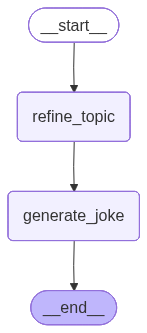

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


In [4]:
# Stream graph state

# Use the stream modes updates and values to stream the state of the graph as it executes.
# updates streams the updates to the state after each step of the graph.
# values streams the full value of the state after each step of the graph.

from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
  topic: str
  joke: str


def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}


def generate_joke(state: State):
    return {"joke": f"This is a joke about {state['topic']}"}

graph = (
  StateGraph(State)
  .add_node(refine_topic)
  .add_node(generate_joke)
  .add_edge(START, "refine_topic")
  .add_edge("refine_topic", "generate_joke")
  .add_edge("generate_joke", END)
  .compile()
)

from IPython.display import Image, display
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

for chunk in graph.stream(
    {"topic": "ice cream"},
    stream_mode="updates",
):
    print(chunk)

In [5]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    stream_mode="values",
):
    print(chunk)

{'topic': 'ice cream'}
{'topic': 'ice cream and cats'}
{'topic': 'ice cream and cats', 'joke': 'This is a joke about ice cream and cats'}


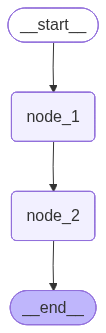

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:e0af1f22-283c-0218-6278-1e88cf8c1b8d',), {'subgraph_node_1': {'bar': 'bar'}})
(('node_2:e0af1f22-283c-0218-6278-1e88cf8c1b8d',), {'subgraph_node_2': {'foo': 'hi! foobar'}})
((), {'node_2': {'foo': 'hi! foobar'}})


In [7]:
# Stream subgraph outputs
from langgraph.graph import START, StateGraph
from typing import TypedDict

# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # note that this key is shared with the parent graph state
    bar: str

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

from IPython.display import Image, display
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

for chunk in graph.stream(
    {"foo": "foo"},
    stream_mode="updates",
    # Set subgraphs=True to stream outputs from subgraphs
    subgraphs=True,
):
    print(chunk)

In [9]:
# LLM Tokens
from dataclasses import dataclass

from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    base_url="http://localhost:12434/engines/v1", #"http://localhost:12434/engines/llama.cpp/v1/"
    api_key="docker",
    temperature=0,
    model="ai/gemma3",  # ai/llama3.2
    stream_usage=True
)

@dataclass
class MyState:
    topic: str
    joke: str = ""


# llm = init_chat_model(model=model)

def call_model(state: MyState):
    """Call the LLM to generate a joke about a topic"""
    # Note that message events are emitted even when the LLM is run using .invoke rather than .stream
    llm_response = llm.invoke(
        [
            {"role": "user", "content": f"Generate a joke about {state.topic}"}
        ]
    )
    return {"joke": llm_response.content}

graph = (
    StateGraph(MyState)
    .add_node(call_model)
    .add_edge(START, "call_model")
    .compile()
)

# The "messages" stream mode returns an iterator of tuples (message_chunk, metadata)
# where message_chunk is the token streamed by the LLM and metadata is a dictionary
# with information about the graph node where the LLM was called and other information
for message_chunk, metadata in graph.stream(
    {"topic": "ice cream"},
    stream_mode="messages",
):
    if message_chunk.content:
        print(message_chunk.content, end="|", flush=True)

Why| did| the| ice| cream| go| to| therapy|?| |

|Because| it| had| too| many| scoops| of| sadness|!| 😄| |

|---|

|Would| you| like| to| hear| another| joke|?|

In [13]:
# Filter by tags
from typing import TypedDict

from langchain.chat_models import init_chat_model
from langgraph.graph import START, StateGraph

# The joke_model is tagged with "joke"
joke_model = init_chat_model(
    model="ai/phi4",
    model_provider="openai",
    base_url="http://localhost:12434/engines/v1",
    api_key="docker", tags=["joke"])
# The poem_model is tagged with "poem"
poem_model = init_chat_model(
    model="ai/phi4",
    model_provider="openai",
    base_url="http://localhost:12434/engines/v1",
    api_key="docker", tags=["poem"])


class State(TypedDict):
      topic: str
      joke: str
      poem: str


async def call_model(state, config):
      topic = state["topic"]
      print("Writing joke...")
      # Note: Passing the config through explicitly is required for python < 3.11
      # Since context var support wasn't added before then: https://docs.python.org/3/library/asyncio-task.html#creating-tasks
      # The config is passed through explicitly to ensure the context vars are propagated correctly
      # This is required for Python < 3.11 when using async code. Please see the async section for more details
      joke_response = await joke_model.ainvoke(
            [{"role": "user", "content": f"Write a joke about {topic}"}],
            config,
      )
      print("\n\nWriting poem...")
      poem_response = await poem_model.ainvoke(
            [{"role": "user", "content": f"Write a short poem about {topic}"}],
            config,
      )
      return {"joke": joke_response.content, "poem": poem_response.content}


graph = (
      StateGraph(State)
      .add_node(call_model)
      .add_edge(START, "call_model")
      .compile()
)

# The stream_mode is set to "messages" to stream LLM tokens
# The metadata contains information about the LLM invocation, including the tags
async for msg, metadata in graph.astream(
      {"topic": "cats"},
      stream_mode="messages",
):
    if metadata["tags"] == ["joke"]:
        print(msg.content, end="|", flush=True)

Writing joke...
|Why| don|'t| cats| play| poker| in| the| jungle|?

|Cat|itude|!||

Writing poem...


In [4]:
# Streaming
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    topic: str
    joke: str

def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}

def generate_joke(state: State):
    return {"joke": f"This is a joke about {state['topic']}"}

graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .add_edge("generate_joke", END)
    .compile()
)

# The stream() method returns an iterator that yields streamed outputs
for chunk in graph.stream(
    {"topic": "ice cream"},
    # Set stream_mode="updates" to stream only the updates to the graph state after each node
    # Other stream modes are also available. See supported stream modes for details
    stream_mode="updates",
):
    print(chunk)

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


In [14]:
# Filter by node
from typing import TypedDict
from langgraph.graph import START, StateGraph
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="gpt-4o-mini")


class State(TypedDict):
      topic: str
      joke: str
      poem: str


def write_joke(state: State):
      topic = state["topic"]
      joke_response = model.invoke(
            [{"role": "user", "content": f"Write a joke about {topic}"}]
      )
      return {"joke": joke_response.content}


def write_poem(state: State):
      topic = state["topic"]
      poem_response = model.invoke(
            [{"role": "user", "content": f"Write a short poem about {topic}"}]
      )
      return {"poem": poem_response.content}


graph = (
      StateGraph(State)
      .add_node(write_joke)
      .add_node(write_poem)
      # write both the joke and the poem concurrently
      .add_edge(START, "write_joke")
      .add_edge(START, "write_poem")
      .compile()
)

# The "messages" stream mode returns a tuple of (message_chunk, metadata)
# where message_chunk is the token streamed by the LLM and metadata is a dictionary
# with information about the graph node where the LLM was called and other information
for msg, metadata in graph.stream(
    {"topic": "cats"},
    stream_mode="messages",
):
    # Filter the streamed tokens by the langgraph_node field in the metadata
    # to only include the tokens from the write_poem node
    if msg.content and metadata["langgraph_node"] == "write_poem":
        print(msg.content, end="|", flush=True)

With| velvet| paws| and| eyes| of| gold|,|
|A| silent| hunter|,| stories| told|.|
|A| pur|ring| rumble|,| soft| and| deep|,|
|Lost| in| a| sun|beam|,| fast| asleep|.|

|A| graceful| stretch|,| a| playful| leap|,|
|Secrets| held| in| slumber| deep|.|
|Independent|,| wild|,| and| free|,|
|A| feline| mystery|,| you| see|.|

In [15]:
# Stream custom data
# node

from typing import TypedDict
from langgraph.config import get_stream_writer
from langgraph.graph import StateGraph, START

class State(TypedDict):
    query: str
    answer: str

def node(state: State):
    # Get the stream writer to send custom data
    writer = get_stream_writer()
    # Emit a custom key-value pair (e.g., progress update)
    writer({"custom_key": "Generating custom data inside node"})
    return {"answer": "some data"}

graph = (
    StateGraph(State)
    .add_node(node)
    .add_edge(START, "node")
    .compile()
)

inputs = {"query": "example"}

# Set stream_mode="custom" to receive the custom data in the stream
for chunk in graph.stream(inputs, stream_mode="custom"):
    print(chunk)

{'custom_key': 'Generating custom data inside node'}


In [ ]:
# Use with any LLM
from langgraph.config import get_stream_writer

def call_arbitrary_model(state):
    """Example node that calls an arbitrary model and streams the output"""
    # Get the stream writer to send custom data
    writer = get_stream_writer()
    # Assume you have a streaming client that yields chunks
    # Generate LLM tokens using your custom streaming client
    for chunk in your_custom_streaming_client(state["topic"]):
        # Use the writer to send custom data to the stream
        writer({"custom_llm_chunk": chunk})
    return {"result": "completed"}

graph = (
    StateGraph(State)
    .add_node(call_arbitrary_model)
    # Add other nodes and edges as needed
    .compile()
)
# Set stream_mode="custom" to receive the custom data in the stream
for chunk in graph.stream(
    {"topic": "cats"},
    stream_mode="custom",

):
    # The chunk will contain the custom data streamed from the llm
    print(chunk)

In [16]:
# Streaming arbitrary model
import operator
import json

from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START

from openai import AsyncOpenAI

openai_client = AsyncOpenAI(
    api_key="docker",
    base_url="http://localhost:12434/engines/v1",
)
model_name = "ai/gemma3"


async def stream_tokens(model_name: str, messages: list[dict]):
    response = await openai_client.chat.completions.create(
        messages=messages, model=model_name, stream=True
    )
    role = None
    async for chunk in response:
        delta = chunk.choices[0].delta

        if delta.role is not None:
            role = delta.role

        if delta.content:
            yield {"role": role, "content": delta.content}


# this is our tool
async def get_items(place: str) -> str:
    """Use this tool to list items one might find in a place you're asked about."""
    writer = get_stream_writer()
    response = ""
    async for msg_chunk in stream_tokens(
        model_name,
        [
            {
                "role": "user",
                "content": (
                    "Can you tell me what kind of items "
                    f"i might find in the following place: '{place}'. "
                    "List at least 3 such items separating them by a comma. "
                    "And include a brief description of each item."
                ),
            }
        ],
    ):
        response += msg_chunk["content"]
        writer(msg_chunk)

    return response


class State(TypedDict):
    messages: Annotated[list[dict], operator.add]


# this is the tool-calling graph node
async def call_tool(state: State):
    ai_message = state["messages"][-1]
    tool_call = ai_message["tool_calls"][-1]

    function_name = tool_call["function"]["name"]
    if function_name != "get_items":
        raise ValueError(f"Tool {function_name} not supported")

    function_arguments = tool_call["function"]["arguments"]
    arguments = json.loads(function_arguments)

    function_response = await get_items(**arguments)
    tool_message = {
        "tool_call_id": tool_call["id"],
        "role": "tool",
        "name": function_name,
        "content": function_response,
    }
    return {"messages": [tool_message]}


graph = (
    StateGraph(State)
    .add_node(call_tool)
    .add_edge(START, "call_tool")
    .compile()
)

In [17]:
inputs = {
    "messages": [
        {
            "content": None,
            "role": "assistant",
            "tool_calls": [
                {
                    "id": "1",
                    "function": {
                        "arguments": '{"place":"bedroom"}',
                        "name": "get_items",
                    },
                    "type": "function",
                }
            ],
        }
    ]
}

async for chunk in graph.astream(
    inputs,
    stream_mode="custom",
):
    print(chunk["content"], end="|", flush=True)

Okay|,| here| are| at| least| |3| items| you| might| find| in| a| bedroom|,| with| a| brief| description| of| each|:|

|Bed|,| a| large| piece| of| furniture| designed| for| sleeping|,| typically| with| a| mattress| and| bedding|.|
|Night|stand|,| a| small| table| placed| beside| a| bed| for| holding| a| lamp|,| books|,| or| personal| items|.|
|D|resser|,| a| piece| of| furniture| with| drawers| used| for| storing| clothes|.|

|Would| you| like| me| to| list| more| items|,| or| perhaps| focus| on| a| specific| type| of| bedroom| (|e|.|g|.,| a| child|’|s| bedroom|,| a| master| bedroom|)?|